In [296]:
import numpy as np
import scipy
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
import tensorflow.keras as tfk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({
    "ytick.major.size": 0.1,
    "ytick.minor.size": 0.05,
    "axes.edgecolor": "0.1",
    "axes.linewidth": .7,
    "grid.linestyle": ":"
    
})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    'legend.title_fontsize': 'x-large',
    'legend.fontsize': 'x-large',
    'figure.figsize': (8,4),
    'axes.labelsize': 20,
    'axes.titlesize':'x-large',
    'xtick.labelsize':16,
    'ytick.labelsize':15
})

sns.set_style("whitegrid")
import math
import copy
import pickle

from cymetric.pointgen.pointgen_mathematica import PointGeneratorMathematica
from cymetric.pointgen.pointgen import PointGenerator
from cymetric.models.tfhelper import prepare_tf_basis
from cymetric.models.fubinistudy import FSModel

# Function definitions

In [297]:
class Spectrum:
    def __init__(self, ambient, monomials, k_phi, metric_model):
        self.ambient = ambient
        self.monomials = monomials
        self.degrees = self.ambient + 1
        self.ncoords = int(tf.reduce_sum(self.degrees))
        self.nfold = ambient - 1
        self.k = k_phi
        self.metric_model = metric_model
        self._init_monomials(k_phi)

    def _init_monomials(self, k):
        self.k = [k for _ in range(len(self.ambient))]
        self._generate_sections(self.k)

    def get_eigenfunction_basis(self, c_pts):
        # expects complex points
        c_pts = tf.cast(c_pts, tf.complex128)
        s_i = self.eval_sections_vec(c_pts)
        bs_j = self.eval_sections_vec(tf.math.conj(c_pts))
        sbs = tf.reshape(tf.einsum('xi,xj->xij', s_i, bs_j), (c_pts.shape[0], s_i.shape[-1]**2,))
        return tf.einsum('xa, x->xa', sbs, 1. / tf.einsum('xi,xi->x', c_pts, tf.math.conj(c_pts)) ** self.k)
        
    @tf.function
    def o_ab(self, points, weights=None, ambient=False):
        # this expects real points
        # fs is eigenfunction basis, i.e. sections of O(k), Dimension [x, a]
        if ambient:
            self._generate_sections(self.k, ambient=True)
        if weights is None:
            weights = tf.ones((points.shape[0]))
        points = tf.cast(points, dtype=tf.float64)
        c_pts = tf.complex(points[:, :self.ncoords], points[:, self.ncoords:])
        fs = self.get_eigenfunction_basis(c_pts)
        weights = tf.cast(weights, tf.complex128)
        return 1. / fs.shape[0] * tf.einsum('xa,xb,x->ab', tf.math.conj(fs), fs, weights)

    def delta(self, points, weights=None, omegas=None, ambient=False, verbose=1):
        total_num_pts = points.shape[0]
        if ambient:
            self._generate_sections(self.k, ambient=True)
        if weights is None:
            weights = tf.ones((total_num_pts,))
        # find n_chunks (max_chunk_size is 15k for GPU and 50k for CPU)
        max_chunk_size = 15000 if tf.config.list_physical_devices('GPU') else 50000
        if max_chunk_size == 15000:
            if verbose > 0: print("Batching for GPU use...")
        else:
            if verbose > 0: print("Batching for CPU use...")
        if total_num_pts <= max_chunk_size:
            n_chunks = 1
        else:
            n_chunks = -1
            for i in range(5000, max_chunk_size, 5000):
                if total_num_pts % i == 0:
                    n_chunks = total_num_pts//i
            if n_chunks == -1:
                n_chunks = total_num_pts//5000
                points = points[:n_chunks * 5000]
                weights = weights[:n_chunks * 5000]
                total_num_pts = points.shape[0]
                if verbose > 0: print("Warning, throwing away some points when batching")
                
        if verbose > 0: print("Divided {} points into {} batches with {} points each".format(total_num_pts, n_chunks, total_num_pts//n_chunks))
        batched_points = tf.reshape(points, (n_chunks, total_num_pts//n_chunks, points.shape[-1]))
        batched_weights = tf.reshape(weights, (n_chunks, total_num_pts//n_chunks))
        if omegas is not None:
            batched_omegas = tf.reshape(omegas, (n_chunks, total_num_pts//n_chunks))
        else: 
            batched_omegas = [None] * n_chunks
        
        #  do not parallelize this with joblib. reduce_sum + tf is parallelizing the computation automatically, and if you parallelize with joblib it actually gets slower
        if not ambient:
            return tf.reduce_sum([self.delta_cy_batched(bpts, bws, total_num_pts, bos, verbose) for bpts, bws, bos in zip(batched_points, batched_weights, batched_omegas)], axis=0)
        else:
            return tf.reduce_sum([self.delta_amb_batched(bpts, total_num_pts, verbose) for bpts in batched_points], axis=0)
    
    @tf.function
    def delta_cy_batched(self, points, weights, total_num_pts=None, omegas=None, verbose=1):
        # this expects real points
        # also note that we use omegas for g_inv, so actually it should be 1/omegas
        # first, we find the good coordinates, i.e. those that are not patch coords and that are not eliminated
        pts = tf.cast(points, dtype=tf.float64)
        if total_num_pts is None:
            total_num_pts = pts.shape[0]
        c_pts = tf.complex(pts[:, :self.ncoords], pts[:, self.ncoords:])
        bc_pts = tf.math.conj(c_pts)
        weights = tf.cast(weights, tf.complex128)
        
        if verbose > 0: print("Computing pullbacks...")
        pbs = tf.cast(self.metric_model.pullbacks(tf.cast(pts, tf.float32)), tf.complex128)  # shape [x, 1, 3]
        
        if verbose > 0: print("Computing derivatives...")
        # when tf computes complex derivatives, it does (don't ask why...):
        # df/dz = (del f/del z +del f/del z*)* = 2 d re(f)/ dz*
        # so we need to do the below to get the usual df/dz
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(c_pts)
            fs = self.get_eigenfunction_basis(c_pts)
            fs1 = tf.math.real(fs)
            fs2 = tf.math.imag(fs)
        
        if verbose > 0: print("Computing inverse metrics...")
        g_inv = tf.cast(tf.linalg.inv(self.metric_model(points)), tf.complex128)  # shape [x, 1, 1]
        
        bjac1 = .5 * t1.batch_jacobian(fs1, c_pts)  # = d re(f)/ dz*
        bjac2 = .5 * t1.batch_jacobian(fs2, c_pts)  # = d im(f)/ dz*
        
        di_bfs = tf.math.conj(bjac1) - 1.j * tf.math.conj(bjac2)  # shape [x, number of fs, 3]
        di_bfs = tf.einsum('xai,xri->xar',di_bfs, pbs)
        di_bfs = tf.cast(di_bfs, tf.complex128)
        
        dbi_fs = bjac1 + 1.j * bjac2
        dbi_fs = tf.einsum('xai,xri->xar',dbi_fs, tf.math.conj(pbs))
        dbi_fs = tf.cast(dbi_fs, tf.complex128)
        
        if omegas is not None:
            g_inv = tf.reshape(tf.cast(omegas, tf.complex128), (omegas.shape[0], 1, 1))
        if verbose > 0: print("Carrying out matrix products...")
        return 2./total_num_pts * (tf.einsum('xai, xij, xbj, x->ab', di_bfs, g_inv, dbi_fs, weights))
    
    @tf.function
    def delta_amb_batched(self, points, total_num_pts=None, verbose=1):
        # this expects real points
        # first, we find the good coordinates, i.e. those that are not patch coords and that are not eliminated
        pts = tf.cast(points, dtype=tf.float64)
        if total_num_pts is None:
            total_num_pts = pts.shape[0]
        c_pts = tf.complex(pts[:, :self.ncoords], pts[:, self.ncoords:])
        bc_pts = tf.math.conj(c_pts)
        
        if verbose > 0: print("Computing pullbacks...")
        pbs = tf.cast(self.remove_patch_coord_matrix(points), tf.complex64)
        
        if verbose > 0: print("Computing derivatives...")
        # when tf computes complex derivatives, it does (don't ask why...):
        # df/dz = (del f/del z +del f/del z*)* = 2 d re(f)/ dz*
        # so we need to do the below to get the usual df/dz
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(c_pts)
            fs = self.get_eigenfunction_basis(c_pts)
            fs1 = tf.math.real(fs)
            fs2 = tf.math.imag(fs)
        
        if verbose > 0: print("Computing inverse metrics...")
        g = self.metric_model._fubini_study_n_metrics(c_pts, t=fs_model.BASIS['KMODULI'][0])
        g = tf.einsum('xai,xij,xbj->xab', pbs, g, pbs)
        g_inv = tf.cast(tf.linalg.inv(g), tf.complex128)  # shape [x, 2, 2]
        
        if verbose > 0: print("Pulling back derivatives...")
        bjac1 = .5 * t1.batch_jacobian(fs1, c_pts)  # = d re(f)/ dz*
        bjac2 = .5 * t1.batch_jacobian(fs2, c_pts)  # = d im(f)/ dz*
        
        di_bfs = tf.math.conj(bjac1) - 1.j * tf.math.conj(bjac2)  # shape [x, number of fs, 3]
        di_bfs = tf.cast(di_bfs, tf.complex128)
        pbs = tf.cast(pbs, tf.complex128)
        di_bfs = tf.einsum('xai,xri->xra', pbs, di_bfs) # shape [x, number of fs, 2]
        
        dbi_fs = bjac1 + 1.j * bjac2
        dbi_fs = tf.cast(dbi_fs, tf.complex128)
        dbi_fs = tf.einsum('xai,xri->xra', pbs, dbi_fs) # shape [x, number of fs, 2]
        
        if verbose > 0: print("Carrying out matrix products...")
        return 2./total_num_pts * tf.reduce_sum(tf.einsum('xai, xji, xbj->xab', di_bfs, g_inv, dbi_fs), axis=0)
    
    def get_good_coords_mask(self, points):
        inv_one_mask = self.metric_model._get_inv_one_mask(tf.cast(points, tf.float32))
        cpoints = tf.complex(points[:, :self.ncoords], points[:, self.ncoords:])
        dQdz_indices = self.metric_model._find_max_dQ_coords(points)
        full_mask = tf.cast(inv_one_mask, dtype=tf.float32)
        for i in range(len(self.ambient)):
            dQdz_mask = -1. * tf.one_hot(dQdz_indices[:, i], self.ncoords)
            full_mask = tf.math.add(full_mask, dQdz_mask)
        n_p = tf.cast(tf.reduce_sum(tf.ones_like(full_mask[:, 0])), dtype=tf.int64)
        full_mask = tf.cast(full_mask, dtype=tf.bool)
        return full_mask
 
    def get_good_coords(self, points):
        full_mask = self.get_good_coords_mask(points)
        x_z_indices = tf.where(full_mask)
        return x_z_indices[:, 1:2]
    
    def generate_monomials(self, n, deg):
        if n == 1:
            yield (deg,)
        else:
            for i in range(deg + 1):
                for j in self.generate_monomials(n - 1, deg - i):
                    yield (i,) + j
    
    @tf.function
    def remove_patch_coord_matrix(self, points):
        # expects real points 
        inv_one_mask = self.metric_model._get_inv_one_mask(tf.cast(points, tf.float32))
        cpoints = tf.complex(points[:, :self.ncoords], points[:, self.ncoords:])
        full_mask = tf.cast(inv_one_mask, dtype=tf.float32)
        full_mask = tf.cast(full_mask, dtype=tf.bool)
        pullbacks = tf.eye(self.ambient[0] + 1, batch_shape=(points.shape[0],))
        pullbacks = tf.reshape(tf.boolean_mask(pullbacks, full_mask, axis=None), (points.shape[0],self.ambient[0], self.ambient[0] + 1))
        return pullbacks  # [x, ambient, ambient + 1]
    
    def _generate_sections(self, k, ambient=False):
        self.sections = None
        ambient_polys = [0 for i in range(len(k))]
        for i in range(len(k)):
            # create all monomials of degree k in ambient space factors
            ambient_polys[i] = list(self.generate_monomials(self.degrees[i], k[i]))
        # create all combinations for product of projective spaces
        monomial_basis = [x for x in ambient_polys[0]]
        for i in range(1, len(k)):
            lenB = len(monomial_basis)
            monomial_basis = monomial_basis*len(ambient_polys[i])
            for l in range(len(ambient_polys[i])):
                for j in range(lenB):
                    monomial_basis[l*lenB+j] = monomial_basis[l * lenB + j] + ambient_polys[i][l]
        sections = np.array(monomial_basis, dtype=np.int32)
        # reduce sections; pick (arbitrary) first monomial in point gen
        if not ambient:
            reduced = np.unique(np.where(sections - self.monomials[0] < -0.1)[0])
            sections = sections[reduced]
        self.sections = tf.cast(sections, tf.complex128)
        self.nsections = len(self.sections)

    def eval_sections_vec(self, points):
        return tf.reduce_prod(tf.math.pow(tf.expand_dims(points, 1), self.sections), axis=-1)

    @staticmethod
    def get_exact_eigenspectrum_t2(tau, n_max, m_max):
        return sorted([4 * np.pi**2 / np.imag(tau)**2 * np.abs(n - m*tau)**2 for n in range(-n_max, n_max+1) for m in range(-m_max, m_max+1)])
        
    def get_exact_eigenspectrum_amb(self): 
        def get_degeneracy(m):
            return int(1./2. * (m + 1)**2 * (2*m + 2))
        eigenspec = [[4 * np.pi**2 / (np.sqrt(2) * np.pi) * k * (k + 2)] * get_degeneracy(k) for k in range(self.k[0] + 1)]
        return [item for sublist in eigenspec for item in sublist]
    
    @staticmethod
    def get_cluster_label(eig_vals, tol):
        cluster_labels = []
        curr_cluster = 0
        if len(eig_vals) == 0:
            return cluster_labels
        elif len(eig_vals) == 1:
            return [0]
        
        for i, x in enumerate(eig_vals):
            if i > 0 and abs(x - eig_vals[i-1]) > tol:
                curr_cluster += 1
            cluster_labels += [curr_cluster]
        return cluster_labels
            

# Spectrum computation T^2

In [86]:
dim_amb = 2
psi = -1
num_pts = 10000
kmoduli = np.ones(1)
k_phi = 2
dirname = 'fermat_pgmath'

ambient = np.array([dim_amb])
monomials = np.append((dim_amb + 1) * np.eye(dim_amb + 1, dtype=np.int64), np.array([[1] * (dim_amb + 1)]), 0)
coefficients = np.array([1] * (dim_amb + 1) + [-(dim_amb + 1) * psi])

# prepare point gen and fs model for this CS choice
point_gen = PointGeneratorMathematica([monomials], [coefficients], kmoduli, ambient, verbose=0)
kappa = point_gen.prepare_dataset(num_pts, dirname, ltails=0)
point_gen.prepare_basis(dirname);
data = np.load(os.path.join(dirname, 'dataset.npz'))
BASIS = np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True)
BASIS = prepare_tf_basis(BASIS)
fs_model = FSModel(BASIS)

WolframKernel-<tcp://127.0.0.1:53987>:INFO:Connected to logging socket: tcp://127.0.0.1:53987
WolframKernel-<tcp://127.0.0.1:53987>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 10 Mathematica kernels.
/Users/ruehle/venv-mcts/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/ruehle/venv-mcts/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [88]:
# normalize volume
vol = 0.98657  # psi=-1
# vol = 2.72336  # psi=-100
weights = vol / tf.reduce_mean(data['y_train'][:,0]) * data['y_train'][:,0]
omegas = vol / tf.reduce_mean(2**(2*dim_amb/2) * weights * data['y_train'][:,1]) * data['y_train'][:,1]
print("Vol |O|^2: {:.4f}\nVol J_CY:  {:.4f}\nVol J_FS:  {:.4f}".format(tf.reduce_mean(weights), tf.reduce_mean(2**(2*dim_amb/2) * weights * omegas), np.pi/3 * tf.reduce_mean(2**(2*dim_amb/2) * tf.cast(tf.linalg.det(fs_model(data['X_train'])), tf.float64) * weights)))

Vol |O|^2: 0.9866
Vol J_CY:  0.9866
Vol J_FS:  0.9555


In [89]:
spec = Spectrum(ambient, monomials, k_phi, fs_model)
o_ab = spec.o_ab(data['X_train'], weights)
delta_cy = spec.delta(data['X_train'], weights, 1./omegas)
delta_fs = spec.delta(data['X_train'], weights)
eig_vals_cy_all = math.factorial(dim_amb)**(1/dim_amb) * (np.sqrt(2) * np.pi) * abs(scipy.linalg.eigh(delta_cy, o_ab, eigvals_only=True))
eig_vals_fs_all = math.factorial(dim_amb)**(1/dim_amb) * (np.sqrt(2) * np.pi) * abs(scipy.linalg.eigh(delta_fs, o_ab, eigvals_only=True))

Batching for GPU use...
Divided 9000 points into 1 batches with 9000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Batching for GPU use...
Divided 9000 points into 1 batches with 9000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...


In [90]:
eig_vals_cy = eig_vals_cy_all[1:25]
eig_vals_fs = eig_vals_fs_all[1:25]
eig_vals_exact_all = [0., 40.5605, 40.5605, 40.5605, 40.5605, 67.871, 67.871, 94.3711, 94.3711, 162.242, 162.242, 162.242, 162.242, 176.303, 176.303, 176.303, 176.303, 229.303, 229.303, 229.303, 229.303, 271.484, 271.484, 365.045, 365.045, 365.045, 365.045, 365.855, 365.855, 365.855, 365.855, 377.484, 377.484, 445.355, 445.355, 445.355, 445.355, 447.787, 447.787, 447.787, 447.787, 606.787, 606.787, 606.787, 606.787, 610.839, 610.839, 636.529, 636.529, 636.529, 636.529, 648.968, 648.968, 648.968, 648.968, 705.21, 705.21, 705.21, 705.21, 742.529, 742.529, 742.529, 742.529, 849.34, 849.34, 855.013, 855.013, 855.013, 855.013, 917.211, 917.211, 917.211, 917.211, 988.323, 988.323, 988.323, 988.323, 1014.01, 1014.01, 1014.01, 1014.01, 1043.75, 1043.75, 1043.75, 1043.75, 1085.94, 1085.94, 1120.82, 1120.82, 1120.82, 1120.82, 1173.01, 1173.01, 1173.01, 1173.01, 1180.31, 1180.31, 1180.31, 1180.31, 1308.76, 1308.76, 1308.76, 1308.76, 1397.98, 1397.98, 1397.98, 1397.98, 1421.24, 1421.24, 1421.24, 1421.24, 1460.18, 1460.18, 1460.18, 1460.18, 1463.42, 1463.42, 1463.42, 1463.42, 1509.94, 1509.94, 1577.81, 1577.81, 1577.81, 1577.81, 1580.24, 1580.24, 1580.24, 1580.24, 1586.72, 1586.72, 1586.72, 1586.72, 1696.78, 1696.78, 1781.42, 1781.42, 1781.42, 1781.42, 1791.15, 1791.15, 1791.15, 1791.15, 1927.98, 1927.98, 1927.98, 1927.98, 1935.28, 1935.28, 1935.28, 1935.28, 1964.21, 1964.21, 1964.21, 1964.21, 1987.47, 1987.47, 1987.47, 1987.47, 2063.72, 2063.72, 2063.72, 2063.72, 2074.26, 2074.26, 2074.26, 2074.26, 2076.69, 2076.69, 2076.69, 2076.69, 2120.78, 2120.78, 2120.78, 2120.78, 2265.43, 2265.43, 2265.43, 2265.43, 2335.21, 2335.21, 2335.21, 2335.21, 2359.28, 2359.28, 2427.15, 2427.15, 2427.15, 2427.15, 2443.36, 2443.36, 2530.43, 2530.43, 2530.43, 2530.43, 2537.73, 2537.73, 2537.73, 2537.73, 2546.12, 2546.12, 2546.12, 2546.12]  # psi=-1
eig_vals_exact = np.array(eig_vals_exact_all)[1:25]

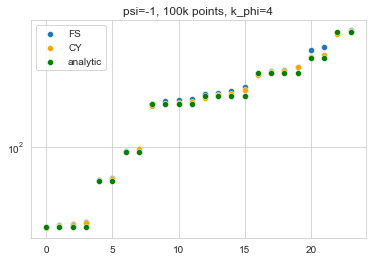

In [91]:
sns.scatterplot(x=range(len(eig_vals_fs)), y=eig_vals_fs, label='FS');
sns.scatterplot(x=range(len(eig_vals_cy)), y=1.08*eig_vals_cy, color='orange', label='CY');
sns.scatterplot(x=range(len(eig_vals_exact)), y=eig_vals_exact, color='green', label='analytic')
plt.title("psi=-1, 100k points, k_phi=4");
plt.yscale('log')

## Varying complex structure

In [4]:
dim_amb = 2
num_pts = 100000
kmoduli = np.ones(1)
k_phi = 3
ambient = np.array([dim_amb])
monomials = np.append((dim_amb + 1) * np.eye(dim_amb + 1, dtype=np.int64), np.array([[1] * (dim_amb + 1)]), 0)
res_dict_cy, res_dict_fs = {}, {}

psis = [-1, -10, -50, -100, -500]
taus = {
    -1: 0.163337 + 0.98657*1.j,
    -10: 0.5 + 1.62404*1.j,
    -50: 0.5 + 2.3924*1.j,
    -100: 0.5 + 2.72336*1.j,
    -500: 0.5 + 3.49181*1.j
}
vol_norms = { psi: np.imag(taus[psi]) for psi in psis }

for psi in psis:
    print("Processing psi =", psi)
    file_dir = "cubic{:}".format(psi)
    
    # prepare point gen and fs model for this CS choice
    print("\tGenerating points...")
    coefficients = np.array([1] * (dim_amb + 1) + [-(dim_amb + 1) * (-1-1.j) * psi])
    point_gen = PointGeneratorMathematica([monomials], [coefficients], kmoduli, ambient, verbose=0)
    kappa = point_gen.prepare_dataset(num_pts, file_dir, ltails=0)
    point_gen.prepare_basis(file_dir, kappa=kappa);
    data = np.load(os.path.join(file_dir, 'dataset.npz'))
    BASIS = np.load(os.path.join(file_dir, 'basis.pickle'), allow_pickle=True)
    BASIS = prepare_tf_basis(BASIS)
    fs_model = FSModel(BASIS)
    
    # normalize volume
    print("\tNormalizing volumes...")
    vol = vol_norms[psi]
    weights = vol / tf.reduce_mean(data['y_train'][:,0]) * data['y_train'][:,0]
    omegas = vol / tf.reduce_mean(2**(2*dim_amb/2) * weights * data['y_train'][:,1]) * data['y_train'][:,1]
    print("\tVol |O|^2: {:.4f}\n\tVol J_CY:  {:.4f}\n\tVol J_FS:  {:.4f}".format(tf.reduce_mean(weights), tf.reduce_mean(2**(2*dim_amb/2) * weights * omegas), np.pi/3 * tf.reduce_mean(2**(2*dim_amb/2) * tf.cast(tf.linalg.det(fs_model(data['X_train'])), tf.float64) * weights)))

    # compute eigenvalues
    print("\tComputing spectrum...")
    spec = Spectrum(ambient, monomials, k_phi, fs_model)
    o_ab = spec.o_ab(data['X_train'], weights)
    delta_cy = spec.delta(data['X_train'], weights, 1./omegas)
    delta_fs = spec.delta(data['X_train'], weights)
    eig_vals_cy_all = math.factorial(dim_amb)**(1/dim_amb) * (np.sqrt(2) * np.pi) * abs(scipy.linalg.eigh(delta_cy, o_ab, eigvals_only=True))
    eig_vals_fs_all = math.factorial(dim_amb)**(1/dim_amb) * (np.sqrt(2) * np.pi) * abs(scipy.linalg.eigh(delta_fs, o_ab, eigvals_only=True))
    res_dict_cy[psi] = copy.deepcopy(eig_vals_cy_all)
    res_dict_fs[psi] = copy.deepcopy(eig_vals_fs_all)
    

Processing psi = -1
	Generating points...


WolframKernel-<tcp://127.0.0.1:63779>:INFO:Connected to logging socket: tcp://127.0.0.1:63779
WolframKernel-<tcp://127.0.0.1:63779>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 10 Mathematica kernels.


	Normalizing volumes...
	Vol |O|^2: 0.9866
Vol J_CY:  0.9866
Vol J_FS:  0.9771
	Computing spectrum...
Batching for GPU use...
Divided 90000 points into 9 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Batching for GPU use...
Divided 90000 points into 9 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Processing psi = -10
	Generating points...


WolframKernel-<tcp://127.0.0.1:63865>:INFO:Connected to logging socket: tcp://127.0.0.1:63865
WolframKernel-<tcp://127.0.0.1:63865>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 10 Mathematica kernels.


	Normalizing volumes...
	Vol |O|^2: 1.6240
Vol J_CY:  1.6240
Vol J_FS:  1.7874
	Computing spectrum...
Batching for GPU use...
Divided 90000 points into 9 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Batching for GPU use...
Divided 90000 points into 9 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Processing psi = -50
	Generating points...


WolframKernel-<tcp://127.0.0.1:63899>:INFO:Connected to logging socket: tcp://127.0.0.1:63899
WolframKernel-<tcp://127.0.0.1:63899>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 10 Mathematica kernels.


	Normalizing volumes...
	Vol |O|^2: 2.3924
Vol J_CY:  2.3924
Vol J_FS:  2.7729
	Computing spectrum...
Batching for GPU use...
Divided 90000 points into 9 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Batching for GPU use...
Divided 90000 points into 9 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Processing psi = -100
	Generating points...


WolframKernel-<tcp://127.0.0.1:63929>:INFO:Connected to logging socket: tcp://127.0.0.1:63929
WolframKernel-<tcp://127.0.0.1:63929>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 10 Mathematica kernels.


	Normalizing volumes...
	Vol |O|^2: 2.7234
Vol J_CY:  2.7234
Vol J_FS:  3.1736
	Computing spectrum...
Batching for GPU use...
Divided 90000 points into 9 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Batching for GPU use...
Divided 90000 points into 9 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Processing psi = -500
	Generating points...


WolframKernel-<tcp://127.0.0.1:63965>:INFO:Connected to logging socket: tcp://127.0.0.1:63965
WolframKernel-<tcp://127.0.0.1:63965>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 10 Mathematica kernels.


	Normalizing volumes...


tensorflow:WARNING:5 out of the last 5 calls to <function FSModel.fubini_study_pb at 0x177566ca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


	Vol |O|^2: 3.4918
Vol J_CY:  3.4918
Vol J_FS:  4.2118
	Computing spectrum...


tensorflow:WARNING:5 out of the last 5 calls to <function Spectrum.o_ab at 0x2bd915820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Batching for GPU use...
Divided 90000 points into 9 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Batching for GPU use...
Divided 90000 points into 9 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...


In [281]:
with open("t2_varying_psi_cy.pickle", 'wb') as hnd:
    pickle.dump(res_dict_cy, hnd)
with open("t2_varying_psi_fs.pickle", 'wb') as hnd:
    pickle.dump(res_dict_fs, hnd)

### plot spectrum

In [290]:
with open("t2_varying_psi_cy.pickle", 'rb') as hnd:
    res_dict_cy = pickle.load(hnd)
with open("t2_varying_psi_fs.pickle", 'rb') as hnd:
    res_dict_fs = pickle.load(hnd)
res_dict_exact = {psi: Spectrum.get_exact_eigenspectrum_t2(taus[psi], 4, 4) for psi in psis}

In [301]:
vary_psi_df = pd.DataFrame({
        'psi': np.array([[psi] * len(res_dict_cy[psi]) for psi in psis]).flatten().tolist() * 3,
        'eigvals': np.array(list(res_dict_cy.values())).flatten().tolist() + np.array(list(res_dict_fs.values())).flatten().tolist() + np.array(list(res_dict_exact.values())).flatten().tolist(),
        'labels': (['CY'] * (len(res_dict_cy) * len(res_dict_cy[psis[0]]))) + (['FS'] * (len(res_dict_fs) * len(res_dict_fs[psis[0]]))) + (['Exact'] * (len(res_dict_exact) * len(res_dict_exact[psis[0]]))),
        'clusters': [str(x) for x in np.array([Spectrum.get_cluster_label(res_dict_exact[psi], 0.001) for psi in psis]).flatten()] * 3,
        'clusters_labeled': [str(x) + "_CY" for x in np.array([Spectrum.get_cluster_label(res_dict_exact[psi], 0.001) for psi in psis]).flatten()] + [str(x) + "_FS" for x in np.array([Spectrum.get_cluster_label(res_dict_exact[psi], 0.001) for psi in psis]).flatten()] + [str(x) + "_EX" for x in np.array([Spectrum.get_cluster_label(res_dict_exact[psi], 0.001) for psi in psis]).flatten()]
})

In [303]:
# select psi in [-1, -50, -500]
vary_psi_df = vary_psi_df.loc[(vary_psi_df.psi==-1)|(vary_psi_df.psi==-50)|(vary_psi_df.psi==-500)]
vary_psi_df2 = copy.deepcopy(vary_psi_df)
vary_psi_df2['psi'] = vary_psi_df2.psi.astype('str')

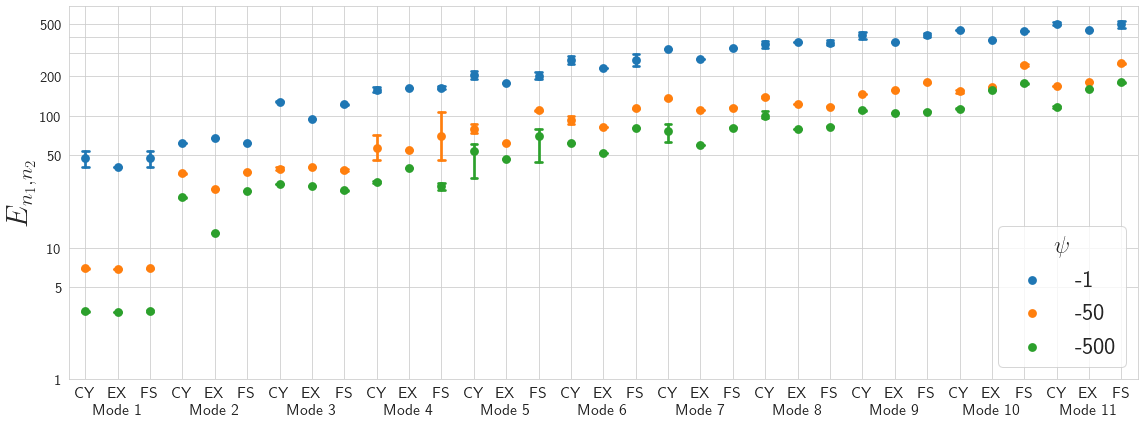

In [307]:
fig = plt.figure(figsize=(16,6))
vary_psi_df2 = copy.deepcopy(vary_psi_df)
vary_psi_df2['psi'] = vary_psi_df2.psi.astype('str')
cat_order = sorted(list(set(vary_psi_df2.loc[vary_psi_df2.clusters.astype('int') > 0].loc[vary_psi_df2.clusters.astype('int') < 10].clusters_labeled))) + sorted(list(set(vary_psi_df2.loc[vary_psi_df2.clusters.astype('int') > 9].loc[vary_psi_df2.clusters.astype('int') < 12].clusters_labeled)))
g = sns.pointplot(x='clusters_labeled', y='eigvals', hue='psi', order=cat_order, join=False, capsize=.2, errorbar=lambda x: (x.min(), x.max()),
                data=vary_psi_df2.loc[vary_psi_df2.clusters.astype('int') > 0].loc[vary_psi_df2.clusters.astype('int') < 12]);
g.set(yscale="log", xlabel=None,
      yticks=[1,5,10,50,100,200,300,400,500], yticklabels=[1,5,10,50,100,200,None,None,500],
      xticks=range(len(cat_order)), xticklabels=[x[-2:]+('\nMode '+str(1 + i//3) if i%3==1 else '') for i, x in enumerate(cat_order)]
     );
g.legend(loc='lower right', title='$\psi$', title_fontsize=24, fontsize=24);
# plt.title("$E_{n_1,n_2}$ vs $\psi$", fontsize=30, pad=20);
plt.ylabel('$E_{n_1,n_2}$', fontsize=30)
plt.grid(axis='x')
plt.tight_layout()
plt.savefig('T2_psi_error.pdf')

## Look at spectrum on P^2

In [42]:
data = np.load(os.path.join(dirname, 'dataset.npz'))
BASIS = np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True)
BASIS = prepare_tf_basis(BASIS)
fs_model = FSModel(BASIS)

In [43]:
# sample points on sphere in P^n
pts = np.random.randn(*data['X_train'].shape)
c_pts = pts[:, :(dim_amb + 1)] + 1.j * pts[:, (dim_amb + 1):]
c_pts = [x/x[np.argmax(np.abs(x))] for x in c_pts]
pts = np.array([np.real(x).tolist() + np.imag(x).tolist() for x in c_pts])

In [57]:
spec = Spectrum(ambient, monomials, k_phi, fs_model)

In [45]:
o_ab = spec.o_ab(pts, ambient=True)

In [46]:
delta_P2 = spec.delta(pts, ambient=True)

Divided 45000 points into 1 batches with 45000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Pulling back derivatives...
Carrying out matrix products...


In [58]:
eig_vals_P2 = abs(scipy.linalg.eigh(delta_P2, o_ab, eigvals_only=True))
eig_vals_exact = np.array(spec.get_exact_eigenspectrum_amb())

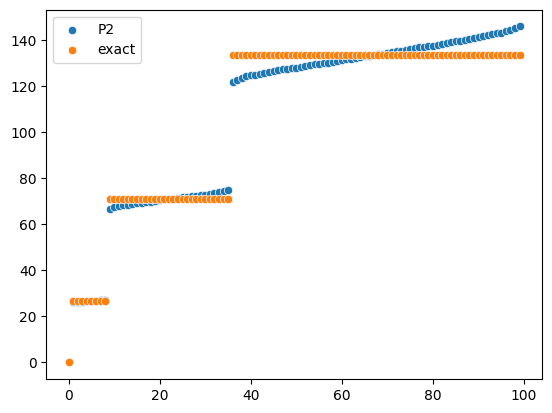

In [69]:
sns.scatterplot(x=range(len(eig_vals_P2)), y=math.factorial(dim_amb)**(1./dim_amb) * eig_vals_P2, label='P2');
sns.scatterplot(x=range(len(eig_vals_exact)), y=eig_vals_exact, label='exact');

## Work out normalization

For psi=-1, we have tau=.1633 - .9866 I, and the volume of the torus us 0.98657. 
So we should normalize our weights s.t. mean(weights) = 0.98657
Also, the Eigenvalues of the scalar Laplacian should be multiplied by (n!)^(1/n) to match the result on CP^n.

In [73]:
dim_amb = 2
psi = -100
num_pts = 500000
kmoduli = np.ones(1)
k_phi = 2
dirname = 'fermat_pgmath'

ambient = np.array([dim_amb])
monomials = np.append((dim_amb + 1) * np.eye(dim_amb + 1, dtype=np.int64), np.array([[1] * (dim_amb + 1)]), 0)
coefficients = np.array([1] * (dim_amb + 1) + [-(dim_amb + 1) * psi])

# prepare point gen and fs model for this CS choice
point_gen = PointGeneratorMathematica([monomials], [coefficients], kmoduli, ambient, verbose=0)
kappa = point_gen.prepare_dataset(num_pts, dirname, ltails=0)
point_gen.prepare_basis(dirname);
data = np.load(os.path.join(dirname, 'dataset.npz'))
BASIS = np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True)
BASIS = prepare_tf_basis(BASIS)
fs_model = FSModel(BASIS)

WolframKernel-<tcp://127.0.0.1:53147>:INFO:Connected to logging socket: tcp://127.0.0.1:53147
WolframKernel-<tcp://127.0.0.1:53147>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 6 Mathematica kernels.
/Users/ruehle/venv-mcts/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/ruehle/venv-mcts/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [74]:
c_pts = data['X_train'][:,:3] + 1.j*data['X_train'][:,3:]
tf.reduce_max(tf.abs(point_gen.cy_condition(c_pts))).numpy() < 1e-9

True

In [77]:
vol = 0.98657  # psi=-1
vol = 2.72336  # psi=-100
weights = vol / tf.reduce_mean(data['y_train'][:,0]) * data['y_train'][:,0]
omegas = vol / tf.reduce_mean(2**(2*dim_amb/2) * weights * data['y_train'][:,1]) * data['y_train'][:,1]

In [78]:
print(tf.reduce_mean(weights), tf.reduce_mean(2**(2*dim_amb/2) * weights * omegas), np.pi/3 * tf.reduce_mean(2**(2*dim_amb/2) * tf.cast(tf.linalg.det(fs_model(data['X_train'])), tf.float64) * weights))

tf.Tensor(2.7233600000000004, shape=(), dtype=float64) tf.Tensor(2.7233599999999996, shape=(), dtype=float64) tf.Tensor(3.2027139435387717, shape=(), dtype=float64)


In [106]:
spec = Spectrum(ambient, monomials, k_phi, fs_model)
o_ab = spec.o_ab(data['X_train'], weights)
delta_cy = spec.delta(data['X_train'], weights, 1./omegas)
delta_fs = spec.delta(data['X_train'], weights)
eig_vals_cy_all = math.factorial(dim_amb)**(1/dim_amb) * (np.sqrt(2) * np.pi) * abs(scipy.linalg.eigh(delta_cy, o_ab, eigvals_only=True))
eig_vals_fs_all = math.factorial(dim_amb)**(1/dim_amb) * (np.sqrt(2) * np.pi) * abs(scipy.linalg.eigh(delta_fs, o_ab, eigvals_only=True))
# eig_vals_exact = [0., 40.5605, 40.5605, 40.5605, 40.5605, 67.871, 67.871, 94.3711, 94.3711, 162.242, 162.242, 162.242, 162.242, 176.303, 176.303, 176.303, 176.303, 229.303, 229.303, 229.303, 229.303, 271.484, 271.484, 365.045, 365.045, 365.045, 365.045, 365.855, 365.855, 365.855, 365.855, 377.484, 377.484, 445.355, 445.355, 445.355, 445.355, 447.787, 447.787, 447.787, 447.787, 606.787, 606.787, 606.787, 606.787, 610.839, 610.839, 636.529, 636.529, 636.529, 636.529, 648.968, 648.968, 648.968, 648.968, 705.21, 705.21, 705.21, 705.21, 742.529, 742.529, 742.529, 742.529, 849.34, 849.34, 855.013, 855.013, 855.013, 855.013, 917.211, 917.211, 917.211, 917.211, 988.323, 988.323, 988.323, 988.323, 1014.01, 1014.01, 1014.01, 1014.01, 1043.75, 1043.75, 1043.75, 1043.75, 1085.94, 1085.94, 1120.82, 1120.82, 1120.82, 1120.82, 1173.01, 1173.01, 1173.01, 1173.01, 1180.31, 1180.31, 1180.31, 1180.31, 1308.76, 1308.76, 1308.76, 1308.76, 1397.98, 1397.98, 1397.98, 1397.98, 1421.24, 1421.24, 1421.24, 1421.24, 1460.18, 1460.18, 1460.18, 1460.18, 1463.42, 1463.42, 1463.42, 1463.42, 1509.94, 1509.94, 1577.81, 1577.81, 1577.81, 1577.81, 1580.24, 1580.24, 1580.24, 1580.24, 1586.72, 1586.72, 1586.72, 1586.72, 1696.78, 1696.78, 1781.42, 1781.42, 1781.42, 1781.42, 1791.15, 1791.15, 1791.15, 1791.15, 1927.98, 1927.98, 1927.98, 1927.98, 1935.28, 1935.28, 1935.28, 1935.28, 1964.21, 1964.21, 1964.21, 1964.21, 1987.47, 1987.47, 1987.47, 1987.47, 2063.72, 2063.72, 2063.72, 2063.72, 2074.26, 2074.26, 2074.26, 2074.26, 2076.69, 2076.69, 2076.69, 2076.69, 2120.78, 2120.78, 2120.78, 2120.78, 2265.43, 2265.43, 2265.43, 2265.43, 2335.21, 2335.21, 2335.21, 2335.21, 2359.28, 2359.28, 2427.15, 2427.15, 2427.15, 2427.15, 2443.36, 2443.36, 2530.43, 2530.43, 2530.43, 2530.43, 2537.73, 2537.73, 2537.73, 2537.73, 2546.12, 2546.12, 2546.12, 2546.12, 2595.87, 2595.87, 2595.87, 2595.87, 2630.76, 2630.76, 2630.76, 2630.76, 2642.92, 2642.92, 2642.92, 2642.92, 2742.43, 2742.43, 2742.43, 2742.43, 2820.84, 2820.84, 2820.84, 2820.84, 2871.69, 2871.69, 2871.69, 2871.69, 2891.14, 2891.14, 2891.14, 2891.14, 2970.12, 2970.12, 2970.12, 2970.12, 3007.44, 3007.44, 3007.44, 3007.44, 3079.88, 3079.88, 3079.88, 3079.88, 3206.71, 3206.71, 3206.71, 3206.71, 3209.14, 3209.14, 3209.14, 3209.14, 3278.92, 3278.92, 3278.92, 3278.92, 3285.4, 3285.4, 3285.4, 3285.4, 3292.7, 3292.7, 3292.7, 3292.7, 3325.68, 3325.68, 3397.36, 3397.36, 3420.05, 3420.05, 3420.05, 3420.05, 3445.21, 3445.21, 3445.21, 3445.21, 3457.37, 3457.37, 3457.37, 3457.37, 3465.23, 3465.23, 3465.23, 3465.23, 3668.84, 3668.84, 3668.84, 3668.84, 3686.15, 3686.15, 3686.15, 3686.15, 3703.16, 3703.16, 3703.16, 3703.16, 3841.34, 3841.34, 3841.34, 3841.34, 3953.29, 3953.29, 3953.29, 3953.29, 3964.11, 3964.11, 3964.11, 3964.11, 4004.15, 4004.15, 4004.15, 4004.15, 4008.2, 4008.2, 4008.2, 4008.2, 4023.6, 4023.6, 4023.6, 4023.6, 4030.08, 4030.08, 4030.08, 4030.08, 4056.05, 4056.05, 4056.05, 4056.05, 4139.89, 4139.89, 4139.89, 4139.89, 4175.02, 4175.02, 4175.02, 4175.02, 4229.11, 4229.11, 4229.11, 4229.11, 4343.74, 4343.74, 4407.56, 4407.56, 4407.56, 4407.56, 4411.37, 4411.37, 4411.37, 4411.37, 4438.12, 4438.12, 4438.12, 4438.12, 4483.3, 4483.3, 4483.3, 4483.3, 4624.18, 4624.18, 4692.06, 4692.06, 4692.06, 4692.06, 4721.23, 4721.23, 4721.23, 4721.23, 4818.6, 4818.6, 4818.6, 4818.6, 4895.67, 4895.67, 4895.67, 4895.67, 4927.27, 4927.27, 4927.27, 4927.27, 5116.01, 5116.01, 5116.01, 5116.01, 5235.02, 5235.02, 5235.02, 5235.02, 5325.34, 5325.34, 5325.34, 5325.34, 5461.08, 5461.08, 5461.08, 5461.08, 5497.55, 5497.55, 5591.92, 5591.92, 5591.92, 5591.92, 5732.57, 5732.57, 5732.57, 5732.57, 6039.75, 6039.75, 6107.62, 6107.62, 6107.62, 6107.62, 6148.95, 6148.95, 6148.95, 6148.95, 6311.24, 6311.24, 6311.24, 6311.24, 6787.1, 6787.1, 6835.28, 6835.28, 6835.28, 6835.28, 6971.02, 6971.02, 6971.02, 6971.02, 7644.06, 7644.06, 7711.93, 7711.93, 7711.93, 7711.93, 8533.96, 8533.96, 8533.96, 8533.96, 9437.11, 9437.11]  # psi=-1
# eig_vals_exact_all = [0., 14.5104, 14.5104, 14.5104, 14.5104, 14.5104, 14.5104, 43.5312, 43.5312, 43.5312, 43.5312, 43.5312, 43.5312, 58.0416, 58.0416, 58.0416, 58.0416, 58.0416, 58.0416, 101.573, 101.573, 101.573, 101.573, 101.573, 101.573, 101.573, 101.573, 101.573, 101.573, 101.573, 101.573, 130.594, 130.594, 130.594, 130.594, 130.594, 130.594, 174.125, 174.125, 188.635, 188.635, 188.635, 188.635, 275.698, 275.698, 275.698, 275.698, 391.781, 391.781]  # psi=0
# eig_vals_exact_all = [0., 3.59882, 3.59882, 14.3953, 14.3953, 32.3894, 32.3894, 44.779, 44.779, 44.779, 44.779, 51.9767, 51.9767, 51.9767, 51.9767, 57.5811, 57.5811, 66.3719, 66.3719, 66.3719, 66.3719, 87.9648, 87.9648, 87.9648, 87.9648, 89.9704, 89.9704, 116.755, 116.755, 116.755, 116.755, 129.557, 129.557, 152.744, 152.744, 152.744, 152.744, 175.517, 175.517, 176.342, 176.342, 179.116, 179.116, 179.116, 179.116, 189.913, 189.913, 189.913, 189.913, 195.929, 195.929, 195.929, 195.929, 207.907, 207.907, 207.907, 207.907, 230.324, 230.324, 233.098, 233.098, 233.098, 233.098, 246.313, 246.313, 246.313, 246.313, 265.488, 265.488, 265.488, 265.488, 291.504, 291.504, 303.894, 303.894, 303.894, 303.894, 305.075, 305.075, 305.075, 305.075, 351.859, 351.859, 351.859, 351.859, 359.882, 359.882, 368.673, 368.673, 368.673, 368.673, 395.814, 395.814, 395.814, 395.814, 403.011, 403.011, 403.011, 403.011, 405.842, 405.842, 405.842, 405.842, 417.407, 417.407, 417.407, 417.407, 438.999, 438.999, 438.999, 438.999, 440.649, 440.649, 467.022, 467.022, 467.022, 467.022, 467.79, 467.79, 467.79, 467.79, 503.778, 503.778, 503.778, 503.778, 535.399, 535.399, 546.964, 546.964, 546.964, 546.964, 597.347, 597.347, 597.347, 597.347, 610.974, 610.974, 654.928, 654.928, 654.928, 654.928, 702.069, 702.069, 705.668, 705.668, 705.668, 705.668, 716.464, 716.464, 716.464, 716.464, 719.707, 719.707, 734.459, 734.459, 734.459, 734.459, 759.65, 759.65, 759.65, 759.65, 791.684, 791.684, 792.04, 792.04, 792.04, 792.04, 831.627, 831.627, 831.627, 831.627, 870.858, 870.858, 878.411, 878.411, 878.411, 878.411, 932.393, 932.393, 932.393, 932.393, 993.573, 993.573, 1061.95, 1061.95, 1097.88, 1097.88, 1097.88, 1097.88, 1105.08, 1105.08, 1105.08, 1105.08, 1119.48, 1119.48, 1119.48, 1119.48, 1137.53, 1137.53, 1141.07, 1141.07, 1141.07, 1141.07, 1169.86, 1169.86, 1169.86, 1169.86, 1205.85, 1205.85, 1205.85, 1205.85, 1220.3, 1220.3, 1249.03, 1249.03, 1249.03, 1249.03, 1299.42, 1299.42, 1299.42, 1299.42, 1357., 1357., 1421.78, 1421.78, 1493.75, 1493.75, 1572.93, 1572.93, 1579.66, 1579.66, 1583.25, 1583.25, 1583.25, 1583.25, 1594.05, 1594.05, 1594.05, 1594.05, 1612.04, 1612.04, 1612.04, 1612.04, 1637.24, 1637.24, 1637.24, 1637.24, 1659.3, 1659.3, 1669.63, 1669.63, 1669.63, 1669.63, 1709.21, 1709.21, 1709.21, 1709.21, 1756., 1756., 1756., 1756., 1809.98, 1809.98, 1871.16, 1871.16, 1939.54, 1939.54, 2015.11, 2015.11, 2097.89, 2097.89, 2150.99, 2150.99, 2150.99, 2150.99, 2158.18, 2158.18, 2158.18, 2158.18, 2172.58, 2172.58, 2172.58, 2172.58, 2187.86, 2187.86, 2194.17, 2194.17, 2194.17, 2194.17, 2222.96, 2222.96, 2222.96, 2222.96, 2258.95, 2258.95, 2258.95, 2258.95, 2302.14, 2302.14, 2302.14, 2302.14, 2352.52, 2352.52, 2410.1, 2410.1, 2474.88, 2474.88, 2546.86, 2546.86, 2626.03, 2626.03, 2712.4, 2712.4, 2805.97, 2805.97, 2808.28, 2808.28, 2811.88, 2811.88, 2811.88, 2811.88, 2822.67, 2822.67, 2822.67, 2822.67, 2840.67, 2840.67, 2840.67, 2840.67, 2865.86, 2865.86, 2865.86, 2865.86, 2898.25, 2898.25, 2898.25, 2898.25, 2937.83, 2937.83, 2937.83, 2937.83, 2984.62, 2984.62, 3038.6, 3038.6, 3099.78, 3099.78, 3168.16, 3168.16, 3243.73, 3243.73, 3326.51, 3326.51, 3416.48, 3416.48, 3513.64, 3513.64, 3555.12, 3555.12, 3555.12, 3555.12, 3562.32, 3562.32, 3562.32, 3562.32, 3576.72, 3576.72, 3576.72, 3576.72, 3598.31, 3598.31, 3598.31, 3598.31, 3627.1, 3627.1, 3627.1, 3627.1, 3663.09, 3663.09, 3663.09, 3663.09, 3706.28, 3706.28, 3756.66, 3756.66, 3814.24, 3814.24, 3879.02, 3879.02, 3950.99, 3950.99, 4030.17, 4030.17, 4116.54, 4116.54, 4210.11, 4210.11, 4310.88, 4310.88, 4387.93, 4387.93, 4391.53, 4391.53, 4391.53, 4391.53, 4402.33, 4402.33, 4402.33, 4402.33, 4420.32, 4420.32, 4420.32, 4420.32, 4445.51, 4445.51, 4445.51, 4445.51, 4477.9, 4477.9, 4477.9, 4477.9, 4517.49, 4517.49, 4564.27, 4564.27, 4618.26, 4618.26, 4679.44, 4679.44, 4747.81, 4747.81, 4823.39, 4823.39, 4906.16, 4906.16, 4996.13, 4996.13, 5093.3, 5093.3, 5197.67, 5197.67]  # psi -500
eig_vals_exact_all = [0., 5.32293, 5.32293, 21.2917, 21.2917, 40.8092, 40.8092, 40.8092, 40.8092, 47.9064, 47.9064, 51.455, 51.455, 51.455, 51.455, 72.7468, 72.7468, 72.7468, 72.7468, 85.1669, 85.1669, 104.684, 104.684, 104.684, 104.684, 133.073, 133.073, 147.268, 147.268, 147.268, 147.268, 157.914, 157.914, 163.237, 163.237, 163.237, 163.237, 179.205, 179.205, 179.205, 179.205, 191.626, 191.626, 200.497, 200.497, 200.497, 200.497, 205.82, 205.82, 205.82, 205.82, 243.081, 243.081, 243.081, 243.081, 260.824, 260.824, 264.372, 264.372, 264.372, 264.372, 290.987, 290.987, 290.987, 290.987, 338.893, 338.893, 338.893, 338.893, 340.668, 340.668, 349.539, 349.539, 349.539, 349.539, 356.636, 356.636, 356.636, 356.636, 367.282, 367.282, 367.282, 367.282, 388.574, 388.574, 388.574, 388.574, 418.737, 418.737, 418.737, 418.737, 420.512, 420.512, 420.512, 420.512, 424.06, 424.06, 424.06, 424.06, 431.158, 431.158, 463.095, 463.095, 463.095, 463.095, 498.581, 498.581, 498.581, 498.581, 516.324, 516.324, 516.324, 516.324, 519.873, 519.873, 519.873, 519.873, 532.293, 532.293, 580.2, 580.2, 580.2, 580.2, 589.071, 589.071, 589.071, 589.071, 626.332, 626.332, 631.655, 631.655, 636.978, 636.978, 636.978, 636.978, 652.946, 652.946, 652.946, 652.946, 654.721, 654.721, 654.721, 654.721, 679.561, 679.561, 679.561, 679.561, 690.207, 690.207, 716.822, 716.822, 716.822, 716.822, 739.888, 739.888, 739.888, 739.888, 764.728, 764.728, 764.728, 764.728, 801.989, 801.989, 823.28, 823.28, 823.28, 823.28, 835.7, 835.7, 892.478, 892.478, 892.478, 892.478, 942.159, 942.159, 972.322, 972.322, 972.322, 972.322, 988.291]

Batching for GPU use...
Divided 450000 points into 45 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Batching for GPU use...
Divided 450000 points into 45 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...


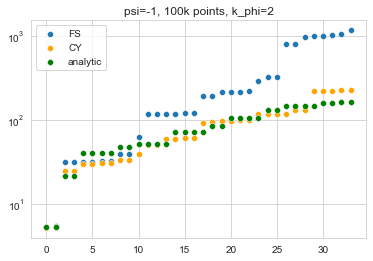

In [116]:
eig_vals_cy = eig_vals_cy_all[1:35]
eig_vals_fs = eig_vals_fs_all[1:35]
eig_vals_exact = eig_vals_exact_all[1:35]

sns.scatterplot(x=range(len(eig_vals_fs)), y=4/10 * eig_vals_fs, label='FS');
sns.scatterplot(x=range(len(eig_vals_cy)), y=35/1000 * eig_vals_cy, color='orange', label='CY');
sns.scatterplot(x=range(len(eig_vals_exact)), y=eig_vals_exact, color='green', label='analytic')
plt.title("psi=-1, 100k points, k_phi=2");
plt.yscale('log')

## Anthony's points

In [ ]:
dim_amb = 2
psi = -1
num_pts = 1000000
kmoduli = np.ones(1)
k_phi = 2
dirname = 'fermat_pgmath'

ambient = np.array([dim_amb])
monomials = np.append((dim_amb + 1) * np.eye(dim_amb + 1, dtype=np.int64), np.array([[1] * (dim_amb + 1)]), 0)
coefficients = np.array([1] * (dim_amb + 1) + [-(dim_amb + 1) * psi])

# prepare point gen and fs model for this CS choice
point_gen = PointGeneratorMathematica([monomials], [coefficients], kmoduli, ambient, verbose=0)
point_gen.prepare_basis(dirname);
BASIS = np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True)
BASIS = prepare_tf_basis(BASIS)
fs_model = FSModel(BASIS)

# pts = np.load('100k.npz')
pts = np.load('anthony.npz')
c_pts = pts[:,:3] + 1.j*pts[:,3:]
point_gen = PointGeneratorMathematica([monomials], [coefficients], kmoduli, ambient)
omegas = tf.cast(point_gen.holomorphic_volume_form(c_pts), tf.complex64)
omegas = omegas * tf.math.conj(omegas)
detg_norm = fs_model(pts)
detg_norm = tf.reshape(detg_norm, detg_norm.shape[0])
weights = tf.math.real(omegas / detg_norm)
# weights = tf.math.real(np.load('anthony_weights.npz'))

In [ ]:
# Check that all points are on the CY
tf.reduce_max(tf.abs(point_gen.cy_condition(c_pts))).numpy() <1e-10

In [ ]:
spec = Spectrum(ambient, monomials, k_phi, fs_model)
o_ab = spec.o_ab(pts, weights)

In [17]:
delta_cy = spec.delta(pts, weights, 1./omegas);
delta_fs = spec.delta(pts, weights);

Batching for GPU use...
Divided 100000 points into 10 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Batching for GPU use...
Divided 100000 points into 10 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...


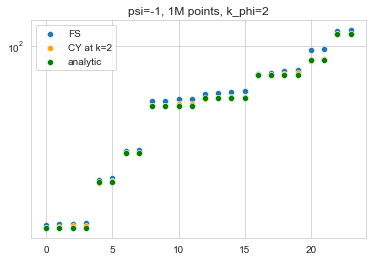

In [19]:
eig_vals_cy = abs(scipy.linalg.eigh(delta_cy, o_ab, eigvals_only=True))[1:25]
eig_vals_fs = abs(scipy.linalg.eigh(delta_fs, o_ab, eigvals_only=True))[1:25]
eig_vals_exact = [0, 12.7374, 12.7374, 12.7374, 12.7374, 21.3139, 21.3139, 29.6358, 29.6358, 50.9497, 50.9497, 50.9497, 50.9497, 55.3652, 55.3652, 55.3652, 55.3652, 72.0091, 72.0091, 72.0091, 72.0091, 85.2555, 85.2555, 114.637, 114.637, 114.637, 114.637, 114.891, 114.891, 114.891, 114.891, 118.543, 118.543, 139.857, 139.857, 139.857, 139.857, 140.621, 140.621, 140.621, 140.621, 190.552, 190.552, 190.552, 190.552, 191.825, 191.825, 266.723, 266.723]
eig_vals_exact = eig_vals_exact[1:25]
sns.scatterplot(x=range(len(eig_vals_fs)), y=2*eig_vals_fs, label='FS');
sns.scatterplot(x=range(len(eig_vals_cy)), y=1.2*eig_vals_cy, color='orange', label='CY at k=2');
sns.scatterplot(x=range(len(eig_vals_exact)), y=eig_vals_exact, color='green', label='analytic')
plt.title("psi=-1, 1M points, k_phi=2")
plt.yscale('log')

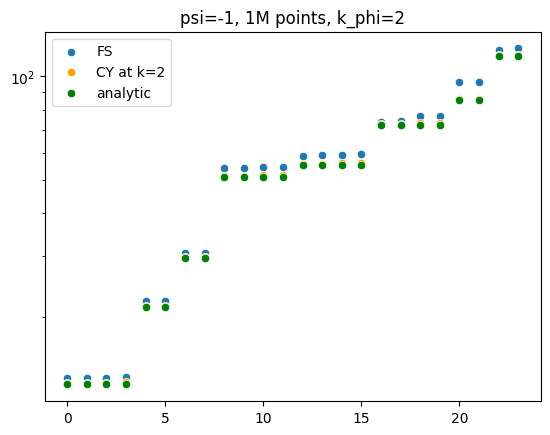

In [227]:
eig_vals_cy = abs(scipy.linalg.eigh(delta_cy, o_ab, eigvals_only=True))[1:25]
eig_vals_fs = abs(scipy.linalg.eigh(delta_fs, o_ab, eigvals_only=True))[1:25]
eig_vals_exact = [0, 12.7374, 12.7374, 12.7374, 12.7374, 21.3139, 21.3139, 29.6358, 29.6358, 50.9497, 50.9497, 50.9497, 50.9497, 55.3652, 55.3652, 55.3652, 55.3652, 72.0091, 72.0091, 72.0091, 72.0091, 85.2555, 85.2555, 114.637, 114.637, 114.637, 114.637, 114.891, 114.891, 114.891, 114.891, 118.543, 118.543, 139.857, 139.857, 139.857, 139.857, 140.621, 140.621, 140.621, 140.621, 190.552, 190.552, 190.552, 190.552, 191.825, 191.825, 266.723, 266.723]
eig_vals_exact = eig_vals_exact[1:25]
sns.scatterplot(x=range(len(eig_vals_fs)), y=2*eig_vals_fs, label='FS');
sns.scatterplot(x=range(len(eig_vals_cy)), y=1.2*eig_vals_cy, color='orange', label='CY at k=2');
sns.scatterplot(x=range(len(eig_vals_exact)), y=eig_vals_exact, color='green', label='analytic')
plt.title("psi=-1, 1M points, k_phi=2")
plt.yscale('log')

# Spectrum computation K3

In [238]:
dim_amb = 3
num_pts = 1000000
kmoduli = np.ones(1)
k_phi = 2
dirname = 'fermat_k3_extra_1M'

ambient = np.array([dim_amb])
monomials = np.append((dim_amb + 1) * np.eye(dim_amb + 1, dtype=np.int64), np.array([[1] * (dim_amb + 1)]), 0)

In [239]:
res_dict = {}
# for psi in np.arange(0, 100, 2):
for psi in [0.3, 0.5, 0.7, 1.9, 2.1]:
    print("Processing psi = -{}(1+I)".format(psi))
    coefficients = np.array([1] * (dim_amb + 1) + [-(dim_amb + 1) * (-1-1.j) * psi])

    # prepare point gen and fs model for this CS choice
    point_gen = PointGeneratorMathematica([monomials], [coefficients], kmoduli, ambient, verbose=0)
    kappa = point_gen.prepare_dataset(num_pts, os.path.join(dirname, str(psi)), ltails=0)
    point_gen.prepare_basis(os.path.join(dirname, str(psi)));
    data = np.load(os.path.join(os.path.join(dirname, str(psi)), 'dataset.npz'))
    BASIS = np.load(os.path.join(os.path.join(dirname, str(psi)), 'basis.pickle'), allow_pickle=True)
    BASIS = prepare_tf_basis(BASIS)
    fs_model = FSModel(BASIS)

    spec = Spectrum(ambient, monomials, k_phi, fs_model)
    o_ab = spec.o_ab(data['X_train'], data['y_train'][:,0])
    delta_fs = spec.delta(data['X_train'], data['y_train'][:,0])
    eig_vals_fs = math.factorial(dim_amb)**(1/dim_amb) * (np.sqrt(2) * np.pi) * abs(scipy.linalg.eigh(delta_fs, o_ab, eigvals_only=True))
    res_dict[psi] = copy.deepcopy(eig_vals_fs)

Processing psi = -0.3(1+I)


WolframKernel-<tcp://127.0.0.1:38879>:INFO:Connected to logging socket: tcp://127.0.0.1:38879
WolframKernel-<tcp://127.0.0.1:38879>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 24 Mathematica kernels.


Batching for CPU use...
Divided 900000 points into 20 batches with 45000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Processing psi = -0.5(1+I)


WolframKernel-<tcp://127.0.0.1:42293>:INFO:Connected to logging socket: tcp://127.0.0.1:42293
WolframKernel-<tcp://127.0.0.1:42293>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 24 Mathematica kernels.


Batching for CPU use...
Divided 900000 points into 20 batches with 45000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Processing psi = -0.7(1+I)


WolframKernel-<tcp://127.0.0.1:39299>:INFO:Connected to logging socket: tcp://127.0.0.1:39299
WolframKernel-<tcp://127.0.0.1:39299>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 24 Mathematica kernels.


Batching for CPU use...
Divided 900000 points into 20 batches with 45000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Processing psi = -1.9(1+I)


WolframKernel-<tcp://127.0.0.1:39065>:INFO:Connected to logging socket: tcp://127.0.0.1:39065
WolframKernel-<tcp://127.0.0.1:39065>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 24 Mathematica kernels.


Batching for CPU use...
Divided 900000 points into 20 batches with 45000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Processing psi = -2.1(1+I)


WolframKernel-<tcp://127.0.0.1:46605>:INFO:Connected to logging socket: tcp://127.0.0.1:46605
WolframKernel-<tcp://127.0.0.1:46605>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 24 Mathematica kernels.


Batching for CPU use...
Divided 900000 points into 20 batches with 45000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...


In [240]:
with open(os.path.join(dirname, "eigenmodes.pickle"), "wb") as hnd:
    pickle.dump(res_dict, hnd)

In [254]:
# combine the datasets:
res_dict3 = copy.deepcopy(res_dict)
dirname = 'fermat_k3_1M'
with open(os.path.join(dirname, "eigenmodes.pickle"), "rb") as hnd:
    res_dict1 = pickle.load(hnd)
dirname = 'fermat_k3'
with open(os.path.join(dirname, "eigenmodes.pickle"), "rb") as hnd:
    res_dict2 = pickle.load(hnd)
res_dict = {}
for i in sorted(list(res_dict1.keys()) + list(res_dict2.keys()) + list(res_dict3.keys())):
    if i in res_dict1.keys():
        res_dict[np.round(i, 1)] = res_dict1[i]
    elif i in res_dict2.keys():
        res_dict[np.round(i, 1)] = res_dict2[i]
    elif i in res_dict3.keys():
        res_dict[np.round(i, 1)] = res_dict3[i]

In [255]:
dirname = 'fermat_k3_combined'
with open(os.path.join(dirname, "eigenmodes.pickle"), "wb") as hnd:
    pickle.dump(res_dict, hnd)

There should be crossings at psi=-1.86212*(1+i) and at psi=-.612372*(1+i)

In [311]:
max_modes = 1+12+3+3+3+12+12
cluster_labels = np.array([
    [0] + [1]*12 + [3]*3 + [5]*3 + [4]*12 + [6]*12 + [2]*3,  # 0.0
    [0] + [1]*12 + [3]*3 + [5]*3 + [4]*12 + [6]*12 + [2]*3,  # 0.2
    [0] + [1]*12 + [3]*3 + [5]*3 + [4]*12 + [6]*12 + [2]*3,  # 0.3
    [0] + [1]*12 + [3]*3 + [5]*3 + [4]*12 + [2]*3 + [6]*12 ,  # 0.4
    [0] + [1]*12 + [3]*3 + [5]*3 + [2]*3 +  [4]*12 + [6]*12, # 0.5
    [0] + [1]*12 + [2]*3 + [3]*3 + [3]*3 +  [4]*12 + [6]*12, # 0.6
    [0] + [1]*12 + [2]*3 + [3]*3 + [3]*3 +  [4]*12 + [6]*12, # 0.7
    [0] + [1]*12 + [2]*3 + [3]*3 + [3]*3 +  [4]*12 + [6]*12, # 0.8
    
    [0] + [1]*12 + [2]*3 + [5]*3 + [3]*3 +  [4]*12 + [6]*12, # 1.0
    [0] + [1]*12 + [2]*3 + [5]*3 + [3]*3 +  [4]*12 + [6]*12, # 1.2
    [0] + [1]*12 + [2]*3 + [5]*3 + [3]*3 +  [4]*12 + [6]*12, # 1.4
    [0] + [1]*12 + [2]*3 + [5]*3 + [3]*3 +  [4]*12 + [6]*12, # 1.6
    [0] + [1]*12 + [2]*3 + [5]*3 + [3]*3 +  [4]*12 + [6]*12, # 1.8
    [0] + [1]*9 + [2]*3 + [1]*3 + [5]*3 + [3]*3 +  [4]*12 + [6]*12, # 1.9
        
    [0] + [1]*6 + [2]*3 + [1]*6 + [5]*3 + [4]*12 + [3]*3 + [6]*12,  # 2.0
    [0] + [1]*3 + [2]*3 + [1]*9 + [5]*3 + [4]*12 + [3]*3 + [6]*12,  # 2.1
    [0] + [2]*3 + [1]*12 + [4]*12 + [5]*3  + [6]*12 + [3]*3,  # 2.2
    [0] + [2]*3 + [1]*12 + [4]*12 + [5]*3 + [6]*12 + [3]*3,  # 2.4
    [0] + [2]*3 + [1]*12 + [4]*12 + [5]*3 + [6]*12 + [3]*3,  # 2.6
    [0] + [2]*3 + [1]*12 + [4]*12 + [5]*3 + [6]*12 + [3]*3,  # 2.8
    
    [0] + [2]*3 + [1]*12 + [3]*3 + [4]*12 + [6]*12 + [3]*3   # 3.0
]).flatten()

all_modes = len(res_dict[0])
k3_df_all = pd.DataFrame({
    'psi': np.array([[-i]*all_modes for i in res_dict.keys()]).flatten(),
    'eig': np.array([x[:all_modes] for x in res_dict.values()]).flatten()
})

k3_df = pd.DataFrame({
    'psi': np.array([[-i]*max_modes for i in res_dict.keys()]).flatten(),
    'eig': np.array([x[:max_modes] for x in res_dict.values()]).flatten(),
    'cluster_labels': [str(x) for x in cluster_labels]
})

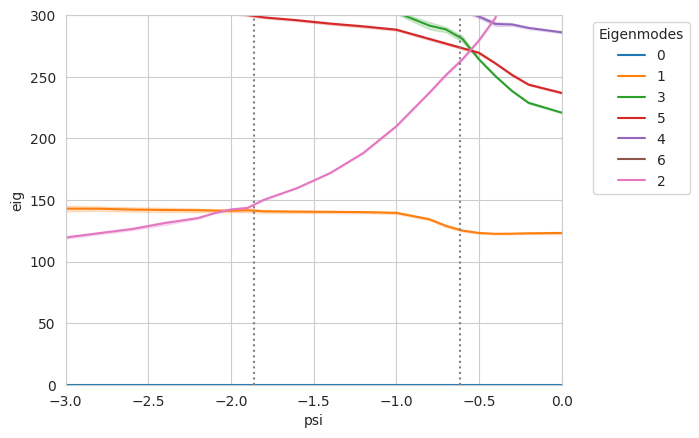

In [312]:
sns.lineplot(x='psi', y='eig', hue="cluster_labels", data=k3_df);
plt.axvline(x=-1.86212, linestyle=':', linewidth=1.5, color='gray')
plt.axvline(x=-0.612372, linestyle=':', linewidth=1.5, color='gray')
plt.legend(title='Eigenmodes', bbox_to_anchor=(1.05, 1), loc='upper left');
plt.ylim([0,300]);
plt.xlim([-3,0]);

In [280]:
k3_df.loc[k3_df.psi==-0.4]

,psi,eig,cluster_labels
102,-0.4,5.917453e-11,0
103,-0.4,1.212347e+02,1
104,-0.4,1.216545e+02,1
105,-0.4,1.217993e+02,1
106,-0.4,1.219426e+02,1
107,-0.4,1.221472e+02,1
108,-0.4,1.222787e+02,1
109,-0.4,1.224995e+02,1
110,-0.4,1.228192e+02,1
111,-0.4,1.229495e+02,1


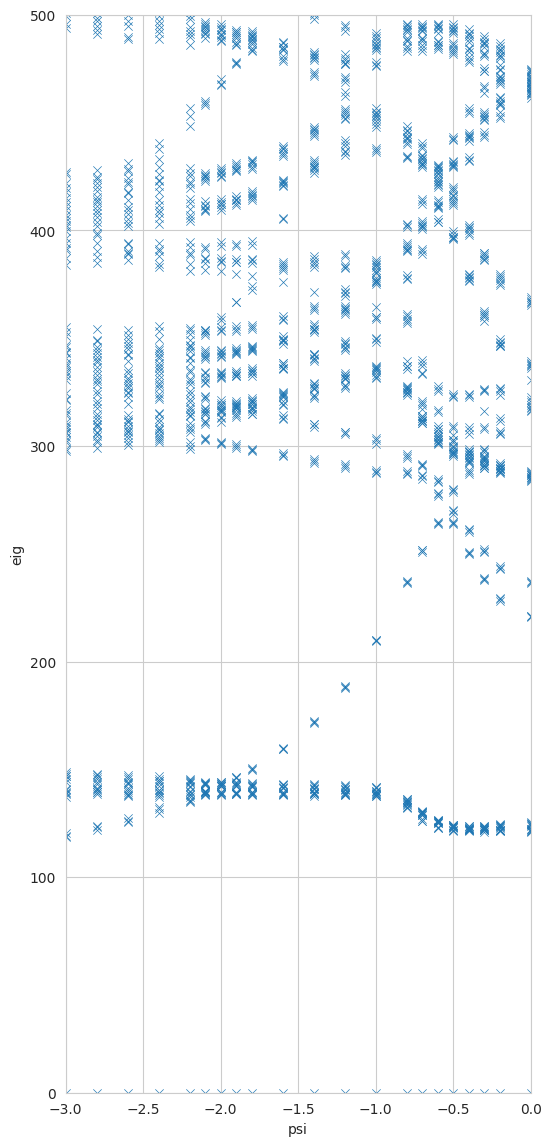

In [267]:
plt.figure(figsize=(6,14));
sns.scatterplot(x='psi', y='eig', data=k3_df_all, marker='x');
plt.ylim([0,500]);
plt.xlim([-3,0]);

# Plots for paper

In [308]:
dim_amb = 2
psi = -1
num_pts = 120000
kmoduli = np.ones(1)
dirname = 'fermat_pgmath'
# workdir = '/home/ruehle/work/ryzen_cluster/cyspectrum'
workdir = '/Users/ruehle/Library/CloudStorage/OneDrive-NortheasternUniversity/ryzen_cluster/cyspectrum'

generate_new_points = False

ambient = np.array([dim_amb])
monomials = np.append((dim_amb + 1) * np.eye(dim_amb + 1, dtype=np.int64), np.array([[1] * (dim_amb + 1)]), 0)
coefficients = np.array([1] * (dim_amb + 1) + [-(dim_amb + 1) * psi])

# prepare point gen and fs model for this CS choice
point_gen = PointGeneratorMathematica([monomials], [coefficients], kmoduli, ambient, verbose=0)
if generate_new_points: kappa = point_gen.prepare_dataset(num_pts, dirname, ltails=0)
point_gen.prepare_basis(dirname);
data = np.load(os.path.join(dirname, 'dataset.npz'))
BASIS = np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True)
BASIS = prepare_tf_basis(BASIS)
fs_model = FSModel(BASIS)

all_pts = [1000, 2000, 3000, 4000, 5000, 10000, 20000, 100000]
all_k_phi = list(range(2, 5))

In [316]:
# check volume normalization
vol = 0.98657  # psi=-1
weights_all = vol / tf.reduce_mean(data['y_train'][:,0]) * data['y_train'][:,0]
omegas = vol / tf.reduce_mean(2**(2*dim_amb/2) * weights_all * data['y_train'][:,1]) * data['y_train'][:,1]
print("Vol |O|^2: {:.4f}\nVol J_CY:  {:.4f}\nVol J_FS:  {:.4f}".format(tf.reduce_mean(weights_all), tf.reduce_mean(2**(2*dim_amb/2) * weights_all * omegas), np.pi/3 * tf.reduce_mean(2**(2*dim_amb/2) * tf.cast(tf.linalg.det(fs_model(data['X_train'])), tf.float64) * weights_all)))

Vol |O|^2: 0.9866
Vol J_CY:  0.9866
Vol J_FS:  0.9495


In [32]:
# for num_pts in all_pts:
#     print("Processing {} points".format(num_pts))
#     for k_phi in all_k_phi:
#         pts, weights, g_invs = data['X_train'][:num_pts], weights_all[:num_pts], 1./omegas[:num_pts]
#         spec = Spectrum(ambient, monomials, k_phi, fs_model)
#         print("\tk_phi = {}: {} sections".format(k_phi, len(spec.sections)))
#         o_ab = spec.o_ab(pts, weights)
#         delta_cy = spec.delta(pts, weights, g_invs)
#         delta_fs = spec.delta(pts, weights)
#         eig_vals_cy = math.factorial(dim_amb)**(1/dim_amb) * (np.sqrt(2) * np.pi) * abs(scipy.linalg.eigh(delta_cy, o_ab, eigvals_only=True))
#         eig_vals_fs = math.factorial(dim_amb)**(1/dim_amb) * (np.sqrt(2) * np.pi) * abs(scipy.linalg.eigh(delta_fs, o_ab, eigvals_only=True))        
#         np.save(os.path.join(workdir, "eig_cy_{}_{}".format(num_pts, k_phi)), eig_vals_cy)
#         np.save(os.path.join(workdir, "eig_fs_{}_{}".format(num_pts, k_phi)), eig_vals_fs)

Processing 1000 points
	k_phi = 2: 6 sections
Batching for GPU use...
Divided 1000 points into 1 batches with 1000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Batching for GPU use...
Divided 1000 points into 1 batches with 1000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
	k_phi = 3: 9 sections
Batching for GPU use...
Divided 1000 points into 1 batches with 1000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Batching for GPU use...
Divided 1000 points into 1 batches with 1000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
	k_phi = 4: 12 sections
Batching for GPU use...
Divided 1000 points into 1 batches with 1000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse 

Carrying out matrix products...
	k_phi = 4: 12 sections
Batching for GPU use...
Divided 20000 points into 2 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Batching for GPU use...
Divided 20000 points into 2 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Processing 100000 points
	k_phi = 2: 6 sections
Batching for GPU use...
Divided 100000 points into 10 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
Batching for GPU use...
Divided 100000 points into 10 batches with 10000 points each
Computing pullbacks...
Computing derivatives...
Computing inverse metrics...
Carrying out matrix products...
	k_phi = 3: 9 sections
Batching for GPU use...
Divided 100000 points into 10 batches with 10000 points each
Computing pullba

In [310]:
# read in points
eig_vals_exact = [0., 40.5605, 40.5605, 40.5605, 40.5605, 67.871, 67.871, 94.3711, 94.3711, 162.242, 162.242, 162.242, 162.242, 176.303, 176.303, 176.303, 176.303, 229.303, 229.303, 229.303, 229.303, 271.484, 271.484, 365.045, 365.045, 365.045, 365.045, 365.855, 365.855, 365.855, 365.855, 377.484, 377.484, 445.355, 445.355, 445.355, 445.355, 447.787, 447.787, 447.787, 447.787, 606.787, 606.787, 606.787, 606.787, 610.839, 610.839, 636.529, 636.529, 636.529, 636.529, 648.968, 648.968, 648.968, 648.968, 705.21, 705.21, 705.21, 705.21, 742.529, 742.529, 742.529, 742.529, 849.34, 849.34, 855.013, 855.013, 855.013, 855.013, 917.211, 917.211, 917.211, 917.211, 988.323, 988.323, 988.323, 988.323, 1014.01, 1014.01, 1014.01, 1014.01, 1043.75, 1043.75, 1043.75, 1043.75, 1085.94, 1085.94, 1120.82, 1120.82, 1120.82, 1120.82, 1173.01, 1173.01, 1173.01, 1173.01, 1180.31, 1180.31, 1180.31, 1180.31, 1308.76, 1308.76, 1308.76, 1308.76, 1397.98, 1397.98, 1397.98, 1397.98, 1421.24, 1421.24, 1421.24, 1421.24, 1460.18, 1460.18, 1460.18, 1460.18, 1463.42, 1463.42, 1463.42, 1463.42, 1509.94, 1509.94, 1577.81, 1577.81, 1577.81, 1577.81, 1580.24, 1580.24, 1580.24, 1580.24, 1586.72, 1586.72, 1586.72, 1586.72, 1696.78, 1696.78, 1781.42, 1781.42, 1781.42, 1781.42, 1791.15, 1791.15, 1791.15, 1791.15, 1927.98, 1927.98, 1927.98, 1927.98, 1935.28, 1935.28, 1935.28, 1935.28, 1964.21, 1964.21, 1964.21, 1964.21, 1987.47, 1987.47, 1987.47, 1987.47, 2063.72, 2063.72, 2063.72, 2063.72, 2074.26, 2074.26, 2074.26, 2074.26, 2076.69, 2076.69, 2076.69, 2076.69, 2120.78, 2120.78, 2120.78, 2120.78, 2265.43, 2265.43, 2265.43, 2265.43, 2335.21, 2335.21, 2335.21, 2335.21, 2359.28, 2359.28, 2427.15, 2427.15, 2427.15, 2427.15, 2443.36, 2443.36, 2530.43, 2530.43, 2530.43, 2530.43, 2537.73, 2537.73, 2537.73, 2537.73, 2546.12, 2546.12, 2546.12, 2546.12]  # psi=-1
labels = Spectrum.get_cluster_label(eig_vals_exact, tol=1e-3)
m_fs = []
m_cy = []
cluster = []
num_pts = []
k_phis = []
m_exact = []
for num_pt in all_pts:
    for k_phi in all_k_phi:
        try:
            eig_cy = np.load(os.path.join(workdir, "eig_cy_{}_{}.npy".format(num_pt, k_phi)))
            eig_fs = np.load(os.path.join(workdir, "eig_fs_{}_{}.npy".format(num_pt, k_phi))) 
            m_fs += eig_fs.tolist()
            m_cy += (1.08 * eig_cy).tolist()
            cluster += labels[:len(eig_fs)]
            num_pts += [num_pt] * len(eig_fs)
            k_phis += [k_phi] * len(eig_fs)
            m_exact += eig_vals_exact[:len(eig_fs)]
        except:
            continue
spectral_data = pd.DataFrame({
    'm_cy': m_cy,
    'm_fs': m_fs,
    'm_exact': m_exact,
    'cluster': [str(x) for x in cluster],
    'num_pts': [x for x in num_pts],
    'k_phi': [str(x) for x in k_phis]
})

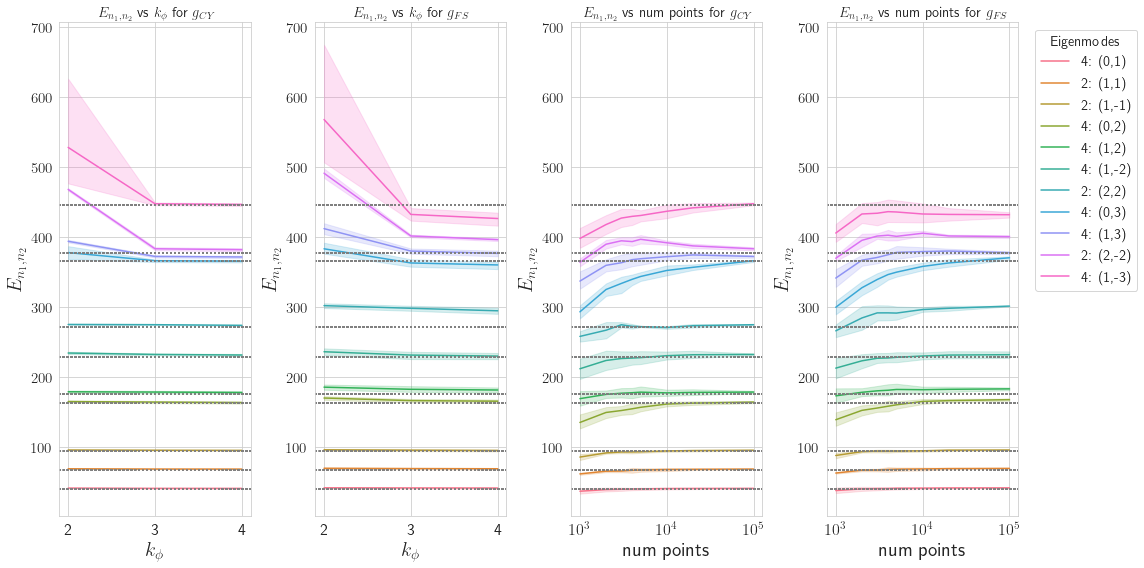

In [314]:
fig = plt.figure(figsize=(16,8))

# kphi CY
ax1 = plt.subplot(141)
sns.lineplot(x='k_phi', y='m_cy', hue='cluster', legend=False, data=spectral_data.loc[spectral_data.cluster.astype('int') > 0].loc[spectral_data.cluster.astype('int') < 12].loc[spectral_data.num_pts == 100000]);
for y in spectral_data.loc[spectral_data.cluster.astype('int') > 0].loc[spectral_data.cluster.astype('int') < 12].m_exact:
    plt.axhline(y=y, linestyle=':', linewidth=1.5, color='gray')
plt.xlabel('$k_\phi$');
plt.ylabel('$E_{n_1,n_2}$');
plt.title("$E_{n_1,n_2}$ vs $k_\phi$ for $g_{CY}$")

# kphi FS
ax2 = plt.subplot(142, sharey=ax1)
sns.lineplot(x='k_phi', y='m_fs', hue='cluster', legend=False, data=spectral_data.loc[spectral_data.cluster.astype('int') > 0].loc[spectral_data.cluster.astype('int') < 12].loc[spectral_data.num_pts == 20000]);
for y in spectral_data.loc[spectral_data.cluster.astype('int') > 0].loc[spectral_data.cluster.astype('int') < 12].m_exact:
    plt.axhline(y=y, linestyle=':', linewidth=1.5, color='gray')
plt.xlabel('$k_\phi$');
plt.ylabel('$E_{n_1,n_2}$');
plt.title("$E_{n_1,n_2}$ vs $k_\phi$ for $g_{FS}$")

# npts CY
ax3 = plt.subplot(143, sharey=ax1)
sns.lineplot(x='num_pts', y='m_cy', hue='cluster', legend=False, data=spectral_data.loc[spectral_data.cluster.astype('int') > 0].loc[spectral_data.cluster.astype('int') < 12].loc[spectral_data.k_phi.astype('int') == 3]);
for y in spectral_data.loc[spectral_data.cluster.astype('int') > 0].loc[spectral_data.cluster.astype('int') < 12].m_exact:
    plt.axhline(y=y, linestyle=':', linewidth=1.5, color='gray')
plt.xlabel('num points');
plt.ylabel('$E_{n_1,n_2}$');
plt.xscale('log')
plt.title("$E_{n_1,n_2}$ vs num points for $g_{CY}$")

# npts FS
ax4 = plt.subplot(144, sharey=ax1)
sns.lineplot(x='num_pts', y='m_fs', hue='cluster', legend=True, data=spectral_data.loc[spectral_data.cluster.astype('int') > 0].loc[spectral_data.cluster.astype('int') < 12].loc[spectral_data.k_phi.astype('int') == 3]);
for y in spectral_data.loc[spectral_data.cluster.astype('int') > 0].loc[spectral_data.cluster.astype('int') < 12].m_exact:
    plt.axhline(y=y, linestyle=':', linewidth=1.5, color='gray')
plt.xlabel('num points');
plt.ylabel('$E_{n_1,n_2}$');
plt.xscale('log')
plt.title("$E_{n_1,n_2}$ vs num points for $g_{FS}$")

# legend
plt_handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Eigenmodes', handles=plt_handles, labels=["4: (0,1)", "2: (1,1)", "2: (1,-1)", "4: (0,2)", "4: (1,2)", "4: (1,-2)", "2: (2,2)", "4: (0,3)", "4: (1,3)", "2: (2,-2)", "4: (1,-3)"], bbox_to_anchor=(1.05, 1), loc='upper left');
fig.tight_layout()

In [393]:
kphi_df = spectral_data.loc[spectral_data.cluster.astype('int') > 0].loc[spectral_data.cluster.astype('int') < 12].loc[spectral_data.num_pts == 100000]

In [394]:
kphi_df2 = pd.DataFrame({
    'eigvals': list(kphi_df['m_cy']) + list(kphi_df['m_fs']) + list(kphi_df['m_exact']),
    'clusters': [str(x) for x in kphi_df.cluster] * 3,
    'clusters_labeled': [str(x) + '_CY' for x in kphi_df.cluster] + [str(x) + '_FS' for x in kphi_df.cluster] + [str(x) + '_EX' for x in kphi_df.cluster],
    'k_phi': (list(kphi_df.loc[kphi_df.k_phi=='2'].k_phi) + list(kphi_df.loc[kphi_df.k_phi=='3'].k_phi) + list(kphi_df.loc[kphi_df.k_phi=='4'].k_phi)) * 3
})

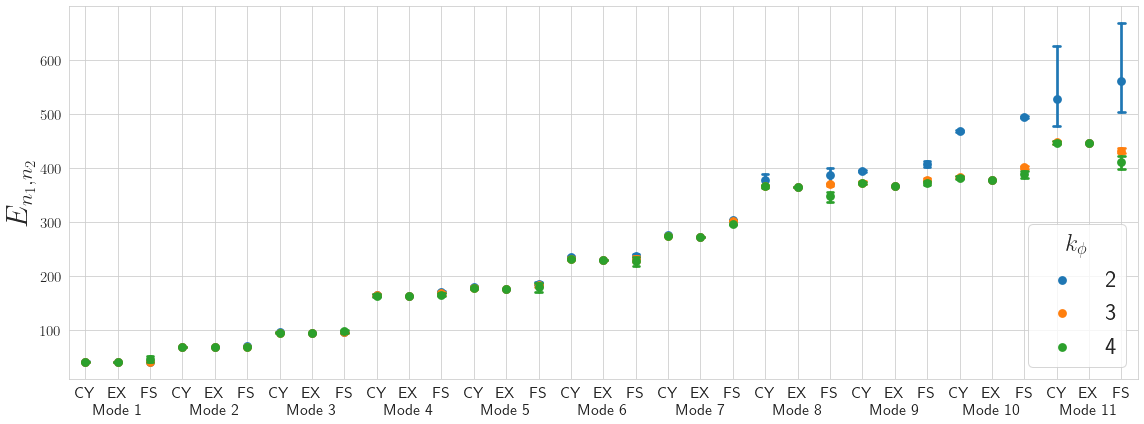

In [401]:
fig = plt.figure(figsize=(16,6))
cat_order = sorted(list(set(kphi_df2.loc[kphi_df2.clusters.astype('int') < 10].clusters_labeled))) + sorted(list(set(kphi_df2.loc[kphi_df2.clusters.astype('int') > 9].clusters_labeled)))
g = sns.pointplot(x='clusters_labeled', y='eigvals', hue='k_phi', order=cat_order, join=False, capsize=.2, errorbar=lambda x: (x.min(), x.max()),
                data=kphi_df2)
g.set(xlabel=None,
      xticks=range(len(cat_order)), xticklabels=[x[-2:]+('\nMode '+str(1 + i//3) if i%3==1 else '') for i, x in enumerate(cat_order)]
     );
g.legend(loc='lower right', title='$k_\phi$', title_fontsize=24, fontsize=24);
# plt.title("$E_{n_1,n_2}$ vs $\psi$", fontsize=30, pad=20);
plt.ylabel('$E_{n_1,n_2}$', fontsize=30)
plt.grid(axis='x')
plt.tight_layout()
plt.savefig('T2_kphi_error.pdf')

In [396]:
kpts_df = spectral_data.loc[spectral_data.cluster.astype('int') > 0].loc[spectral_data.cluster.astype('int') < 12].loc[spectral_data.k_phi == '3'].loc[(spectral_data.num_pts == 1000)|(spectral_data.num_pts == 10000)|(spectral_data.num_pts == 100000)]

In [397]:
kpts_df2 = pd.DataFrame({
    'eigvals': list(kpts_df['m_cy']) + list(kpts_df['m_fs']) + list(kpts_df['m_exact']),
    'clusters': [str(x) for x in kpts_df.cluster] * 3,
    'clusters_labeled': [str(x) + '_CY' for x in kpts_df.cluster] + [str(x) + '_FS' for x in kpts_df.cluster] + [str(x) + '_EX' for x in kpts_df.cluster],
    'num_pts': (list(kpts_df.loc[kpts_df.num_pts==1000].num_pts) + list(kpts_df.loc[kpts_df.num_pts==10000].num_pts) + list(kpts_df.loc[kpts_df.num_pts==100000].num_pts)) * 3
})

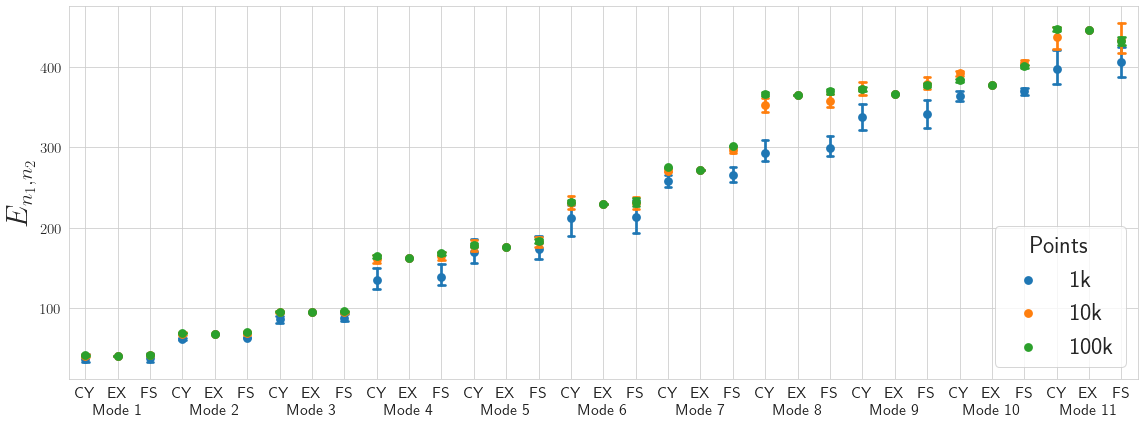

In [400]:
fig = plt.figure(figsize=(16,6))
cat_order = sorted(list(set(kpts_df2.loc[kpts_df2.clusters.astype('int') < 10].clusters_labeled))) + sorted(list(set(kpts_df2.loc[kpts_df2.clusters.astype('int') > 9].clusters_labeled)))
g = sns.pointplot(x='clusters_labeled', y='eigvals', hue='num_pts', order=cat_order, join=False, capsize=.2, errorbar=lambda x: (x.min(), x.max()),
                data=kpts_df2)
g.set(xlabel=None,
      xticks=range(len(cat_order)), xticklabels=[x[-2:]+('\nMode '+str(1 + i//3) if i%3==1 else '') for i, x in enumerate(cat_order)]
     );
plt_handles, labels = plt.gca().get_legend_handles_labels()
g.legend(loc='lower right', title='Points', handles=plt_handles, labels=['1k', '10k', '100k'], title_fontsize=24, fontsize=24);
# plt.title("$E_{n_1,n_2}$ vs $\psi$", fontsize=30, pad=20);
plt.ylabel('$E_{n_1,n_2}$', fontsize=30)
plt.grid(axis='x')
plt.tight_layout()
plt.savefig('T2_numpts_error.pdf')

In [143]:
# compute (num_pts, k_phi, rel_error) for 3D plot in mathematica
all_pts = [1000, 2000, 3000, 4000, 5000, 10000, 20000, 100000]
eig_vals_exact = [0., 40.5605, 40.5605, 40.5605, 40.5605, 67.871, 67.871, 94.3711, 94.3711, 162.242, 162.242, 162.242, 162.242, 176.303, 176.303, 176.303, 176.303, 229.303, 229.303, 229.303, 229.303, 271.484, 271.484, 365.045, 365.045, 365.045, 365.045, 365.855, 365.855, 365.855, 365.855, 377.484, 377.484, 445.355, 445.355, 445.355, 445.355, 447.787, 447.787, 447.787, 447.787, 606.787, 606.787, 606.787, 606.787, 610.839, 610.839, 636.529, 636.529, 636.529, 636.529, 648.968, 648.968, 648.968, 648.968, 705.21, 705.21, 705.21, 705.21, 742.529, 742.529, 742.529, 742.529, 849.34, 849.34, 855.013, 855.013, 855.013, 855.013, 917.211, 917.211, 917.211, 917.211, 988.323, 988.323, 988.323, 988.323, 1014.01, 1014.01, 1014.01, 1014.01, 1043.75, 1043.75, 1043.75, 1043.75, 1085.94, 1085.94, 1120.82, 1120.82, 1120.82, 1120.82, 1173.01, 1173.01, 1173.01, 1173.01, 1180.31, 1180.31, 1180.31, 1180.31, 1308.76, 1308.76, 1308.76, 1308.76, 1397.98, 1397.98, 1397.98, 1397.98, 1421.24, 1421.24, 1421.24, 1421.24, 1460.18, 1460.18, 1460.18, 1460.18, 1463.42, 1463.42, 1463.42, 1463.42, 1509.94, 1509.94, 1577.81, 1577.81, 1577.81, 1577.81, 1580.24, 1580.24, 1580.24, 1580.24, 1586.72, 1586.72, 1586.72, 1586.72, 1696.78, 1696.78, 1781.42, 1781.42, 1781.42, 1781.42, 1791.15, 1791.15, 1791.15, 1791.15, 1927.98, 1927.98, 1927.98, 1927.98, 1935.28, 1935.28, 1935.28, 1935.28, 1964.21, 1964.21, 1964.21, 1964.21, 1987.47, 1987.47, 1987.47, 1987.47, 2063.72, 2063.72, 2063.72, 2063.72, 2074.26, 2074.26, 2074.26, 2074.26, 2076.69, 2076.69, 2076.69, 2076.69, 2120.78, 2120.78, 2120.78, 2120.78, 2265.43, 2265.43, 2265.43, 2265.43, 2335.21, 2335.21, 2335.21, 2335.21, 2359.28, 2359.28, 2427.15, 2427.15, 2427.15, 2427.15, 2443.36, 2443.36, 2530.43, 2530.43, 2530.43, 2530.43, 2537.73, 2537.73, 2537.73, 2537.73, 2546.12, 2546.12, 2546.12, 2546.12]  # psi=-1
all_k_phi = list(range(2, 5))
pts_3d_cy, pts_3d_fs = [], []
def get_rel_error(num_pt, kp, m, spectral_data):
    ms = list(spectral_data.loc[spectral_data.num_pts == num_pt].loc[spectral_data.k_phi == str(kp)][m])
    me = eig_vals_exact[:len(ms)]
    return np.mean([abs(1-s/e) for s,e in zip(ms, me) if e > 0])
    
for num_pt in all_pts:
    for kp in all_k_phi:
        pts_3d_cy += [[num_pt, kp, get_rel_error(num_pt, kp, 'm_cy', spectral_data)]]
        pts_3d_fs += [[num_pt, kp, get_rel_error(num_pt, kp, 'm_fs', spectral_data)]]

In [144]:
[[get_rel_error(num_pt, kp, 'm_cy', spectral_data) for kp in all_k_phi] for num_pt in all_pts]

[[0.11874324371337186, 0.17072890265300772, 0.25851211255122997],
 [0.08928668763009064, 0.0995509783743259, 0.12484186212509252],
 [0.08179378237190615, 0.08414739925118431, 0.09828047905387768],
 [0.07595699646984214, 0.07564966595930837, 0.08536321188509163],
 [0.07140280817638833, 0.06833682122953458, 0.0761466563748898],
 [0.060223902022435764, 0.05504327579166764, 0.05593371333915599],
 [0.05660591054291112, 0.0480262452381862, 0.04572517864594373],
 [0.05305956672323877, 0.040269732194239155, 0.03682297728988487]]

In [145]:
[[get_rel_error(num_pt, kp, 'm_fs', spectral_data) for kp in all_k_phi] for num_pt in all_pts]

[[0.13654995982802007, 0.18362017671819533, 0.2723962702317573],
 [0.10831144883708349, 0.11527404874354885, 0.13717513590878347],
 [0.10149536505283953, 0.103143339901641, 0.11338903238500347],
 [0.09785237099829285, 0.09595359878397991, 0.1015812055729218],
 [0.09429207839080511, 0.09005569105019764, 0.09347027816040408],
 [0.09034247816049554, 0.08253252675102475, 0.08103589972094465],
 [0.08821992001580851, 0.07829604389589115, 0.0748912657579698],
 [0.08761330430412681, 0.07695527728112718, 0.059305733721108055]]